In [1]:
import scanpy as sc
from gtfparse import read_gtf
import pandas as pd
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(5,5),dpi_save=600)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
df = read_gtf("Homo_sapiens.GRCh38.102.gtf",usecols=["gene_name","transcript_id"],
             column_converters={"gene_name": str, "transcript_id": str})
df=df.drop_duplicates(subset="transcript_id")
df.set_index("transcript_id",inplace=True)


tpm=pd.read_table("kallistoDerivedtpmRNASeq_values.tsv")
enst=list(map(lambda t: t.split(".")[1], tpm.index))
common=set.intersection(set(df.index.tolist()),set(enst))

enst=pd.DataFrame({"common":False,"gene":enst},index=enst)
enst.loc[common,"common"]=True
enst.loc[common,"gene"]=df.loc[common,"gene_name"].values
tpm.index=enst.gene.values

INFO:root:Extracted GTF attributes: ['gene_name', 'transcript_id']


In [3]:
tpm=tpm.sum(level=0)

In [4]:
def cor_mat_gpu(A,B):
    import cupy as cp
    A1 = (A-cp.mean(A,axis=0))
    B1 = (B-cp.mean(B,axis=0))
    res = (B1.T.dot(A1)).T/cp.sqrt((A1**2).sum(axis=0).reshape(A1.shape[1],1) @ (B1**2).sum(axis=0).reshape(1,B1.shape[1]))
    return res.T

In [104]:
adata_tree = sc.read('../../SS2/adata_tree_analyzed.h5ad')

In [105]:
sc.pp.neighbors(adata_tree,use_rep='X_diffusion')

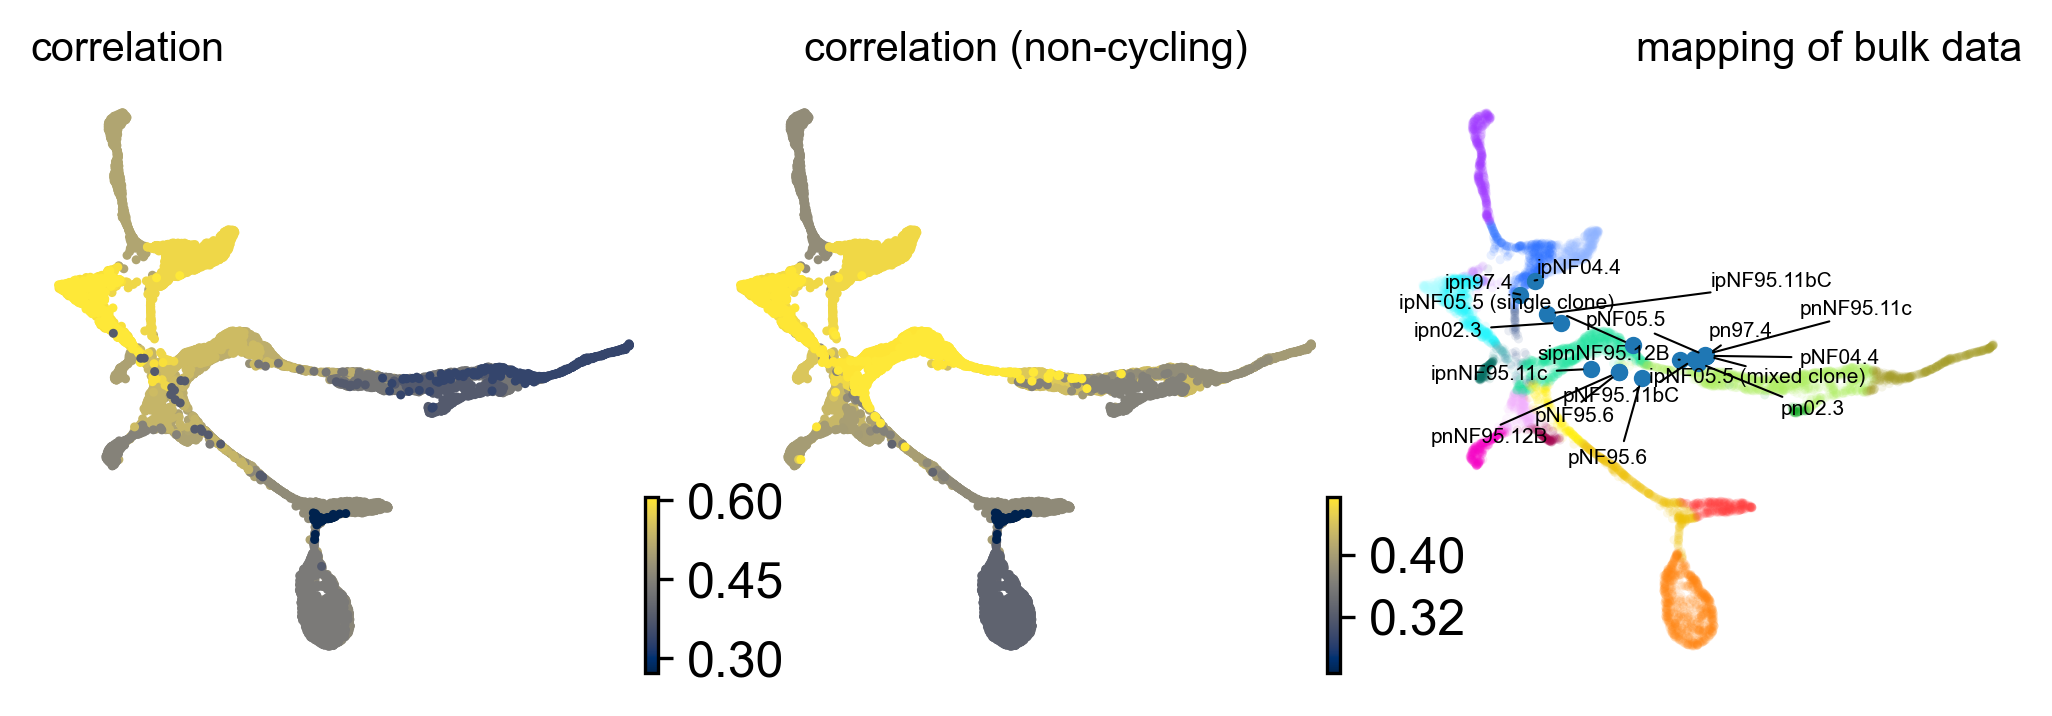

In [150]:
scv.set_figure_params(figsize=(5,5),dpi=150,frameon=False,fontsize=12,dpi_save=600)
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(7,2.5))


adata=sc.read("../../SS2/adata_fpm.h5ad")

adata.var_names=adata.var_names.str.upper()
common=list(set.intersection(set(tpm.index),set(adata.var_names)))
adata=adata[:,common]

import cupy as cp
ss2=cp.array(adata.X)
bulk=cp.array(tpm.loc[common,:].values)
bulk=cp.log10(bulk+1)

cc=cor_mat_gpu(cp.array(adata.obs.cell_cycle.values.reshape(-1,1)),cp.array(adata.X))
cc=pd.Series(cc.get().ravel(),index=adata.var_names)
noncycling=cc[cc<0.1].index

cor=cor_mat_gpu(ss2.T,bulk).T

adata=sc.AnnData(cor.get(),obs=adata.obs,obsm=adata.obsm)

import numpy as np

adata.obs["correlation"]=0
for c in adata.obs.leiden.cat.categories:
    adata.obs.loc[adata.obs.leiden==c,"correlation"] = np.array(adata[adata.obs.leiden==c].X).mean()



scv.pl.umap(adata[(adata.obs.correlation-adata.obs.correlation.mean()).abs().sort_values().index],
            title='',cmap='cividis',color="correlation",sort_order=False,ax=axs[0],show=False)

axs[0].set_title("correlation",loc='left',fontdict={'fontsize':10})


adata=sc.read("../../SS2/adata_fpm.h5ad")
adata.var_names=adata.var_names.str.upper()
ss2=cp.array(adata[:,noncycling].X)
bulk=cp.array(tpm.loc[noncycling,:].values)
bulk=cp.log10(bulk+1)



cor=cor_mat_gpu(ss2.T,bulk).T

adata=sc.AnnData(cor.get(),obs=adata.obs,obsm=adata.obsm)

import numpy as np

adata.obs["correlation"]=0
for c in adata.obs.leiden.cat.categories:
    adata.obs.loc[adata.obs.leiden==c,"correlation"] = np.array(adata[adata.obs.leiden==c].X).mean()



scv.pl.umap(adata[(adata.obs.correlation-adata.obs.correlation.mean()).abs().sort_values().index],show=False,
           cmap='cividis',color="correlation",title="",sort_order=False,ax=axs[1])

axs[1].set_title("correlation (non-cycling)",loc='center',fontdict={'fontsize':10})

X=pd.DataFrame(adata.X.T,index=adata.T.obs_names,columns=adata.T.var_names)
umap_proj=X.apply(lambda b: pd.Series(adata[b.sort_values(ascending=False).index[:5]].obsm["X_umap"].mean(axis=0)),axis=1)
adata_bulk=adata.T
adata_bulk.obsm["X_umap"]=umap_proj.values

scv.pl.umap(adata_tree,ax=axs[2],show=False,legend_loc=False,color="milestones",alpha=0.1,title='')

axs[2].set_title("mapping of bulk data",loc='right',fontdict={'fontsize':10})


#sc.pl.umap(adata_bulk,ax=ax,add_outline=True,size=50)
celllines=["C8581ANXX_7","C8581ANXX_8","C856CANXX_1","C856CANXX_2","C856CANXX_3","C8581ANXX_1",
 "C8581ANXX_2","C8581ANXX_4","C8581ANXX_5","MR1_S1","MR5_S1","MR2_S2","MR19_S2",
 "MR3_S1","MR7_S2","MR4_S2","MR4_S2","MR8_S1"]
cellnames=pd.read_table("metadata.tsv",header=None,index_col=0).loc[celllines,1].values

axs[2].scatter(umap_proj.values[:,0],umap_proj.values[:,1],s=10)

from adjustText import adjust_text
texts = []
for x, y, l in zip(umap_proj.values[:,0].tolist(), 
                   umap_proj.values[:,1].tolist(),
                   cellnames.tolist()):
    texts.append(axs[2].text(x, y, l, fontsize=5))

adjust_text(texts,ax=axs[2],arrowprops=dict(arrowstyle="-", color='k', lw=0.5),
        expand_text=(1.15, 1.15), expand_points=(1.15, 1.15),
        force_text=(0.25, 0.25), force_points=(0.25, 0.25))

plt.tight_layout()

plt.savefig('figures/overview.svg')

In [129]:
axs

array([<AxesSubplot:title={'center':'correlation'}>,
       <AxesSubplot:title={'center':'correlation (non-cycling)'}>,
       <AxesSubplot:title={'center':'milestones'}>], dtype=object)

In [124]:
from matplotlib.colors import hex2color

saving figure to file ./figures/scvelo_correaltion_noCC.png


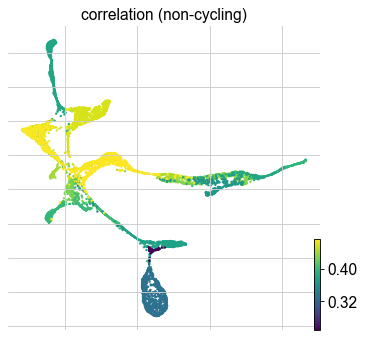

In [111]:
hex2color()

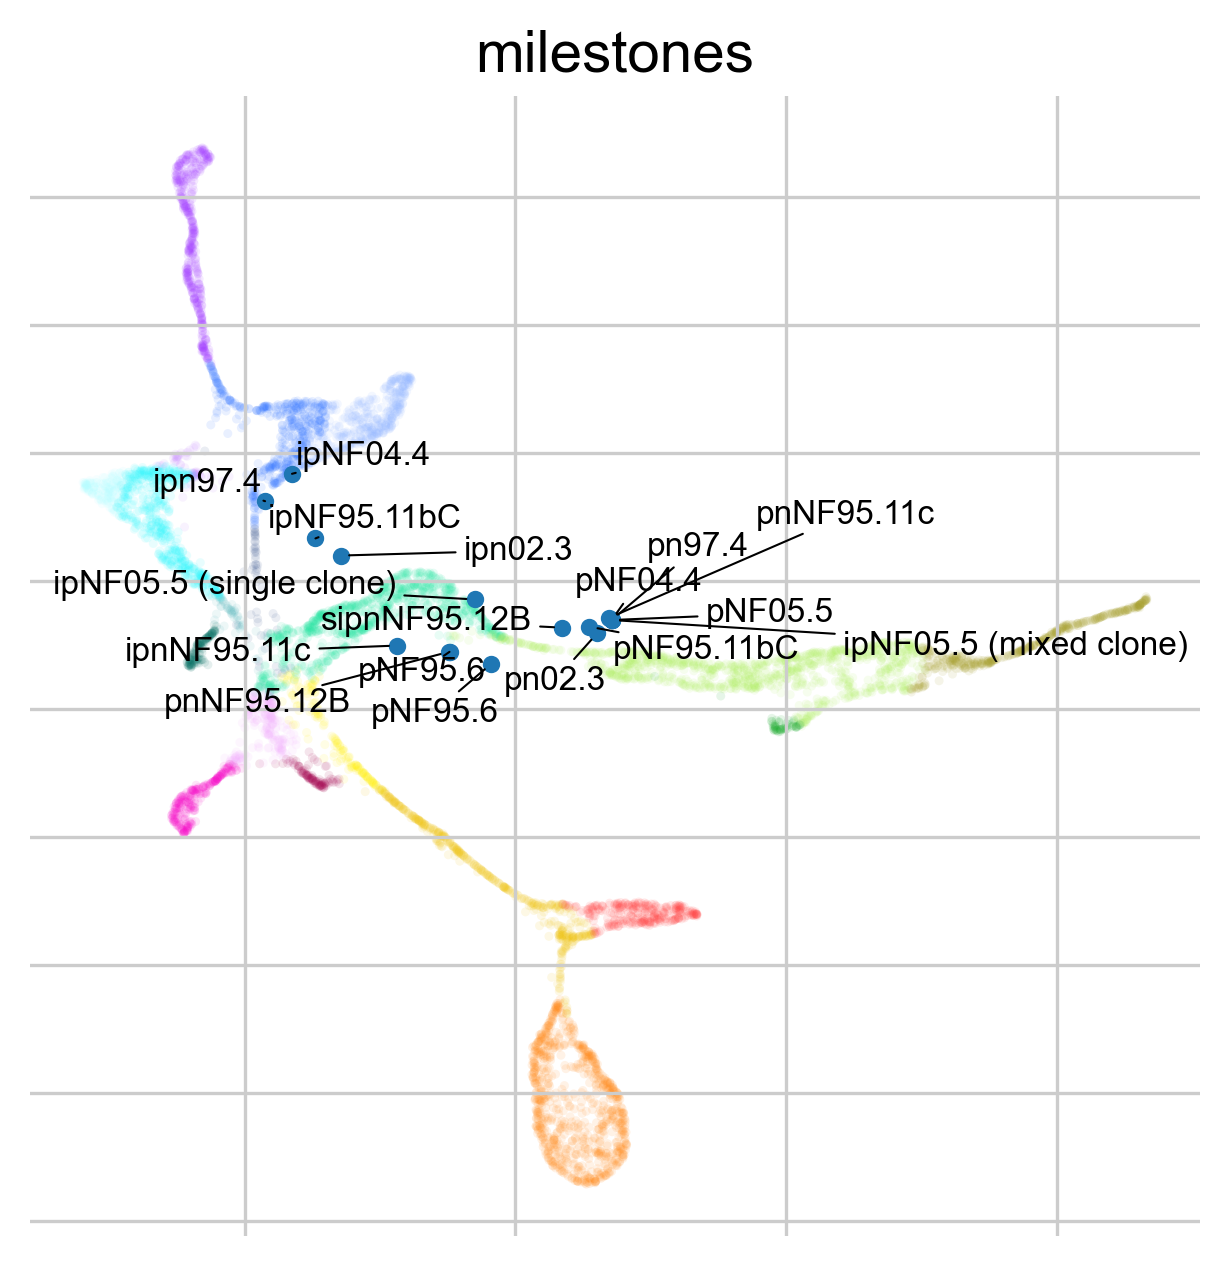

In [127]:


plt.savefig("figures/bulk_mapping_nn5.png",dpi=600)